In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch 
import torch.nn as nn
import os
import json
import math

from models import simpleLSTM, simpleLSTM_quantiles
from utils import run_closed_loop, perf_measure, run_closed_loop_quantile

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


myFmt_year = mdates.DateFormatter('%Y-%m-%d')
myFmt_month_day_time = mdates.DateFormatter('%m-%d-%H:%M')
myFmt_month_day = mdates.DateFormatter('%m-%d')
myFmt = mdates.DateFormatter('%H:%M')

### Iniztialize and load already trained model

In [18]:
experiment_path = "./saved_runs/test_quantiles"
model_name = "best_valid_model.pt"
model_path = os.path.join(experiment_path, model_name)

use_positional_encoding = 'all'
model = simpleLSTM_quantiles(n_input_features=4, num_layers=4)
model.load_state_dict(torch.load(model_path,map_location=torch.device("cpu")))

<All keys matched successfully>

### Plot Train and Validation Loss curve, learning rate schedule

In [19]:
history_path = os.path.join(experiment_path, 'train_history.csv')
df_train_history = pd.read_csv(history_path, index_col=0)

fig = px.line(df_train_history, x = 'epoch', y = ['train_loss', 'valid_loss'])
fig.show()

fig = px.line(df_train_history, x = 'epoch', y = ['learning_rate'])
fig.show()

### Scaled testset data for one split (month)


In [20]:
# Read test data
experiment_path = "./saved_runs/model_with_all_features"
df_test_scaled_list = []
for i in range(6):
    test_data_path = os.path.join(experiment_path, f'test{i}_data_scaled.csv')
    df_test_scaled = pd.read_csv(test_data_path, index_col = 0)
    # Convert timestamps to datetime objects 
    datetime_index = pd.to_datetime(df_test_scaled.index)
    df_test_scaled.index = datetime_index
    df_test_scaled_list.append(df_test_scaled)

fig = px.line(df_test_scaled_list[0], x = df_test_scaled.index, y =  df_test_scaled.columns)
fig.show()

df_test_scaled.head()

,active_power,sun_altitude,sun_azimuth,irradiance_real,irradiance_fc
_time,,,,,
2021-12-16 00:00:00+00:00,0.742399,0.012836,0.928742,0.0,0.0
2021-12-16 00:15:00+00:00,0.764149,0.005641,0.949502,0.0,0.0
2021-12-16 00:30:00+00:00,0.783176,0.000888,0.971321,0.0,0.0
2021-12-16 00:45:00+00:00,0.783190,-0.001236,0.993796,0.0,0.0
2021-12-16 01:00:00+00:00,0.785272,-0.000640,0.016196,0.0,0.0


### Analyze the predictions
In this section we analyze, the performance of the trained demand forecasting algorithm and its effectiveness according to the detection of hurting band linmits. \
We face the scenario of having acces to all historic data. The power $p$, suns altitude $\phi$,  suns azimuth $\theta$, and the original irradiance $\zeta$. \
We have to define the lookback window for initializing the LSTM. This can be either 1hour, 1day, or 2days of the past measurements. For forecasting we use the available forecasts of the irradiance $\zeta_{fc}$. 

In our setting we initialize the LSTM with past data of one day and forecast for the next 24hours. 
The forecasts are used to extract the timepoint and the strenght of the band hurting.

In [27]:
# Read scalings
scaling_data_path = os.path.join(experiment_path,'scalings.json')
with open(scaling_data_path, 'r') as file:
    scaling_dict = json.load(file)

# prepare sclaings to rescale original power profile:
max_power = scaling_dict['active_power']['max']
min_power = scaling_dict['active_power']['min']

max_irradiance = scaling_dict['irradiance_real']['max']
min_irradiance = scaling_dict['irradiance_real']['min']

max_irradiance_fc = scaling_dict['irradiance_fc']['max']
min_irradiance_fc = scaling_dict['irradiance_fc']['min']


months = ['july', 'august', 'september', 'october', 'november', 'december']
tp_list = []
tn_list = []
fp_list = []
fn_list = []

violation_labels_list = []
violation_predictions_list = []
area_of_harm_labels_list = []
area_of_harm_predictions_list = []
time_of_harm_labels_list = []
time_of_harm_predictions_list = []


for k, month in enumerate(months):
    lookback = 96
    predict_forward = 96
    feed_in_limit = -200
    power_treshold = -200 # -159

    violation_labels = []
    violation_predictions = []

    area_of_harm_prediction = []
    area_of_harm_targets = []

    time_of_harm_prediction = []
    time_of_harm_targets = []

    max_harm_prediction = []
    max_harm_targets = []

    df_test_scaled = df_test_scaled_list[k]
    # Convert timestamps to datetime objects 
    datetime_index = pd.to_datetime(df_test_scaled.index)
    df_test_scaled.index = datetime_index
    # Extract unique days
    unique_days_test = pd.Series(datetime_index).dt.date.unique()

    for i in range(len(unique_days_test)-1):
        df_two_days = df_test_scaled.loc[str(unique_days_test[i]): str(unique_days_test[i+1])]
        predictions, predictions_with_quantiles = run_closed_loop_quantile(model, df_two_days.values, lookback=lookback, future_prediction=predict_forward, use_positional_encoding = use_positional_encoding )
        #predictions = predictions_with_quantiles[:,0]
        df_new = pd.DataFrame(columns = ['target', 'prediction', 'delta'])
        df_new['target'] = df_two_days.values[:,0]
        #df_new['index'] = df_new.index
        df_new["irradiance_real"] = df_two_days["irradiance_real"].values
        df_new["irradiance_fc"] = df_two_days["irradiance_fc"].values
        
        df_new.loc[lookback+1:predict_forward+lookback-1, 'prediction'] = predictions
        df_new['prediction'] = df_new['prediction'].fillna(0)
        df_new['target_original'] = df_new['target'] * (max_power - min_power) + min_power # (df_train_val[column] - min_val) / (max_val - min_val)
        df_new['prediction_original'] = df_new['prediction'] * (max_power - min_power) + min_power 
        df_new['irradiance_real_original'] = df_new['irradiance_real'] * (max_irradiance - min_irradiance) + min_irradiance 
        df_new['irradiance_fc_original'] = df_new['irradiance_fc'] * (max_irradiance_fc - min_irradiance_fc) + min_irradiance_fc 

        df_new.index = df_two_days.index

        df_second_day = df_new.iloc[lookback+1::].copy()

        violations_targets_index = df_second_day['target_original'] <= feed_in_limit
        violations_predictions_index = df_second_day['prediction_original'] <= power_treshold # 159 # False negatives verringern, area ofs harms relative klein und zeit kurz, deswegen eher kurz deswegen setzt man das limit runter um sensible anszuschlagen, wenn wir keine Fn haben wollen dannn könnten wir die schwelle runter stellen dann würde es nur zusätzliche 6 

        violation_targets_time = np.sum(violations_targets_index)* 15
        violation_predictions_time = np.sum(violations_predictions_index)* 15
        time_of_harm_targets.append(violation_targets_time)
        time_of_harm_prediction.append(violation_predictions_time)

        violation_targets_sum = np.sum(np.abs(df_second_day[violations_targets_index]['target_original'].values + 200))* 15/60
        violation_predictions_sum = np.sum(np.abs(df_second_day[violations_predictions_index]['prediction_original'].values + 200)) *15/60
        area_of_harm_prediction.append(violation_predictions_sum)
        area_of_harm_targets.append(violation_targets_sum)

        #fig, ax = plt.subplots()
        #ax.plot(df_second_day['target_original'], label = 'target')
        #ax.plot(df_second_day['prediction_original'], label = 'prediction')
        #ax.legend()

        #plt.show()

        max_harm_prediction.append((df_second_day['prediction_original']).min())
        max_harm_targets.append((df_second_day['target_original'].min()))
        #print(violation_targets_values,  'kWh')
        #print(violation_predictions_values, 'kWh')

        #df_new['']
        #print(violations_targets_index)
        #print(violations_predictions_index)

        if (violations_targets_index).any():
            violation_labels.append(1)
        else:
            violation_labels.append(0)

        if (violations_predictions_index).any():
            violation_predictions.append(1)
        else:
            violation_predictions.append(0)
    
    
    #conv_matrix = confusion_matrix(violation_labels, violation_predictions).ravel()
    #print(conv_matrix)
    #tn, fp, fn, tp = conv_matrix.ravel()
    
    (tp, tn, fp, fn) = perf_measure(np.array(violation_labels), np.array(violation_predictions))

    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

    violation_labels_list.append(violation_labels)
    violation_predictions_list.append(violation_predictions)

    area_of_harm_labels_list.append(area_of_harm_targets)
    area_of_harm_predictions_list.append(area_of_harm_prediction)
    time_of_harm_labels_list.append(time_of_harm_targets)
    time_of_harm_predictions_list.append(time_of_harm_prediction)


    print('Month:', month)
    print(f'Number of test days: {len(violation_labels)}')
    print('labels:      ', violation_labels)
    print('prediction:  ', violation_predictions)
    print('area of harm labels[kWh]:      ', area_of_harm_targets)
    print('area of harm prediction[kWh]:  ', area_of_harm_prediction)

    print('max harm labels[kW]:      ', max_harm_targets)
    print('max harm prediction[kW]:  ', max_harm_prediction)

    print('time of harm labels[minutes]:      ', time_of_harm_targets)
    print('time of harm prediction[minutes]:  ', time_of_harm_prediction)

    abs_harm_difference = np.abs(np.array(max_harm_prediction)-np.array(max_harm_targets))
    #print('difference:', abs_harm_difference)
    #print('average_difference:', np.mean(abs_harm_difference))
df_confusion = pd.DataFrame({'month' : months, 'TP' : tp_list,  'TN' : tn_list, 'FP' : fp_list, 'FN' : fn_list})


Month: july
Number of test days: 14
labels:       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prediction:   [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
area of harm labels[kWh]:       [26.47707434181049, 55.006625408724545, 81.61782793409392, 29.543247439032832, 95.20481715399266, 70.7237485480026, 27.788687864123048, 31.61025830769689, 15.487057040365528, 16.92272155664535, 18.534735824739535, 15.008360863511363, 5.87576156657353, 5.009707040870333]
area of harm prediction[kWh]:   [0.0, 136.50994946752007, 75.25573866751145, 16.169099075126276, 94.48694058282882, 129.0016698544536, 127.4835945457516, 0.0, 34.20473241978959, 37.747840140438285, 90.64185643961724, 148.79904647036528, 96.68743110533867, 0.0]
max harm labels[kW]:       [-238.97233752548016, -230.00932342828048, -231.57110554379148, -224.9631459313242, -246.9089584784967, -242.05513103665723, -231.88431259729006, -225.51154387335146, -214.6139046698168, -210.11025950400543, -212.11062924135592, -218.71492601716767, -210.6408

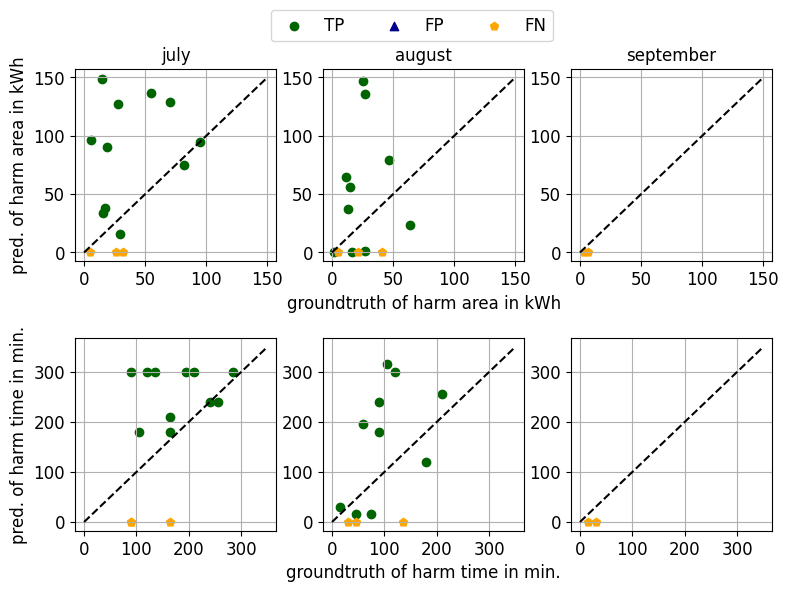

In [28]:
months = ['july', 'august', 'september']

fig, axs = plt.subplots(2,3, figsize= (3*3, 2*3))

for i in range(len(months)):
    month = months[i]
    violation_labels = np.array(violation_labels_list[i])
    violation_predictions = np.array(violation_predictions_list[i])

    area_of_harm_labels = np.array(area_of_harm_labels_list[i])
    area_of_harm_predictions = np.array(area_of_harm_predictions_list[i])

    time_of_harm_labels = np.array(time_of_harm_labels_list[i])
    time_of_harm_predictions = np.array(time_of_harm_predictions_list[i])


    y_actual = violation_labels
    y_pred = violation_predictions
    tp_idx = (y_actual==1) & (y_pred==1)
    #tn = np.sum((y_actual==0) & (y_pred==0))
    fp_idx = (y_actual==0) & (y_pred==1)
    fn_idx = (y_actual==1) & (y_pred==0)

    
    axs[0, i].scatter(area_of_harm_labels[tp_idx], area_of_harm_predictions[tp_idx], label= 'TP', color = 'darkgreen', )
    axs[1, i].scatter(time_of_harm_labels[tp_idx], time_of_harm_predictions[tp_idx], label = 'TP', color = 'darkgreen')

    axs[0, i].scatter(area_of_harm_labels[fp_idx], area_of_harm_predictions[fp_idx], label= 'FP', color = 'darkblue', marker = '^')
    axs[1, i].scatter(time_of_harm_labels[fp_idx], time_of_harm_predictions[fp_idx], label = 'FP', color = 'darkblue', marker = '^')

    axs[0, i].scatter(area_of_harm_labels[fn_idx], area_of_harm_predictions[fn_idx], label= 'FN', color = 'orange', marker = 'p')
    axs[1, i].scatter(time_of_harm_labels[fn_idx], time_of_harm_predictions[fn_idx], label = 'FN', color = 'orange', marker ='p' )
    #axs[0, i].legend()
    #axs[1, i].legend()
    
    if i == 100:
        axs[1, i].plot([0, 40], [0, 40], color = 'black', linestyle='dashed')
        axs[0, i].plot([0, 10], [0, 10], color = 'black', linestyle='dashed')
    else:
        axs[1, i].plot([0, 350], [0, 350], color = 'black', linestyle='dashed')
        axs[0, i].plot([0, 150], [0, 150], color = 'black', linestyle='dashed')

    axs[0, i].grid()
    axs[1, i].grid()

    axs[0,i].set_title(month)

axs[0,1].set_xlabel('groundtruth of harm area in kWh')
axs[1,1].set_xlabel('groundtruth of harm time in min.')

axs[0,0].set_ylabel('pred. of harm area in kWh')
axs[1,0].set_ylabel('pred. of harm time in min.')


plt.subplots_adjust(hspace = 0.4, wspace = 0.23)
axs[0, 1].legend(loc='lower left', bbox_to_anchor=(-0.3,1.1), ncol=3)

plt.savefig("./paper_figures/area_time_of_harm.pdf", bbox_inches='tight')



In [29]:
df_confusion['acc'] = (df_confusion['TP'] + df_confusion['TN']) / (df_confusion['TP'] + df_confusion['TN'] + df_confusion['FP'] + df_confusion['FN'])
df_confusion['precision'] = (df_confusion['TP']) / (df_confusion['TP']+ df_confusion['FP'])
df_confusion['recall'] = (df_confusion['TP']) / (df_confusion['TP']+ df_confusion['FN'])
df_confusion['f1'] = 2 *  df_confusion['precision']*df_confusion['recall']/(df_confusion['precision']+df_confusion['recall'])

df_confusion
#print(df_confusion[['month', 'TP', 'TN', 'FP','FN', 'acc', 'f1']].to_latex(index = False, header= True, float_format="{:.2f}".format))

,month,TP,TN,FP,FN,acc,precision,recall,f1
0,july,11,0,0,3,0.785714,1.0,0.785714,0.880000
1,august,10,1,0,3,0.785714,1.0,0.769231,0.869565
2,september,0,12,0,2,0.857143,NaN,0.000000,NaN
3,october,0,14,0,0,1.000000,NaN,NaN,NaN
4,november,0,14,0,0,1.000000,NaN,NaN,NaN
5,december,0,14,0,0,1.000000,NaN,NaN,NaN


### Midterm-forcasting comparison 
Between irradiance forecasts and (imaginary result of having the original irradiance)

RMSE with irradiance original: 11.698182657792598
RMSE with irradiance fc: 23.138937539896972
MAE with irradiance original: 7.512613479800612
MAE with irradiance fc: 13.826826800318951
RMSE with irradiance original: 15.404335698965616
RMSE with irradiance fc: 35.62507811457484
MAE with irradiance original: 9.143126023183768
MAE with irradiance fc: 19.781346943526806
RMSE with irradiance original: 23.874934467045602
RMSE with irradiance fc: 36.50407655922444
MAE with irradiance original: 13.84825261052427
MAE with irradiance fc: 20.880907607087078
RMSE with irradiance original: 19.36027309073996
RMSE with irradiance fc: 21.73451047075218
MAE with irradiance original: 13.283618191819578
MAE with irradiance fc: 14.325392619744525
RMSE with irradiance original: 17.340152336303408
RMSE with irradiance fc: 16.95137070091053
MAE with irradiance original: 10.763417620959578
MAE with irradiance fc: 10.793116441285527
RMSE with irradiance original: 14.87322636511974
RMSE with irradiance fc: 13.3

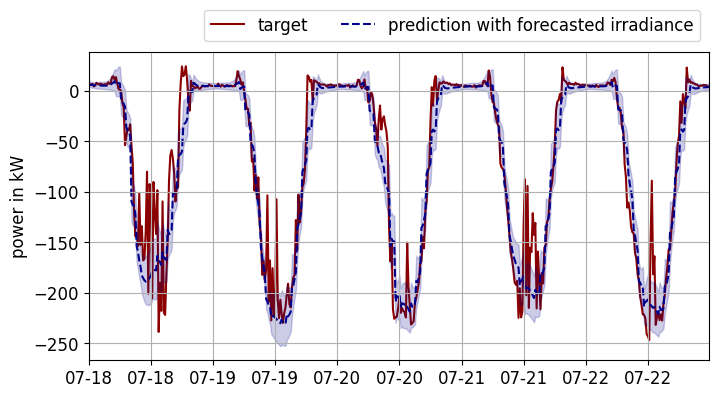

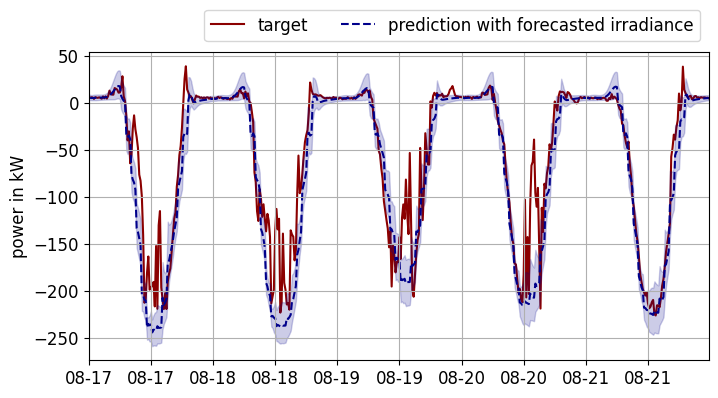

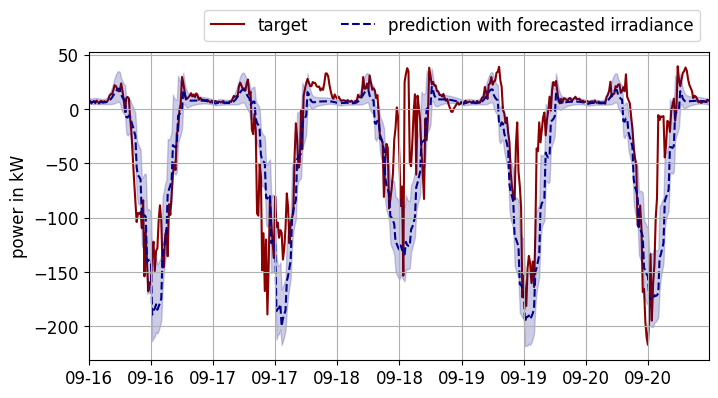

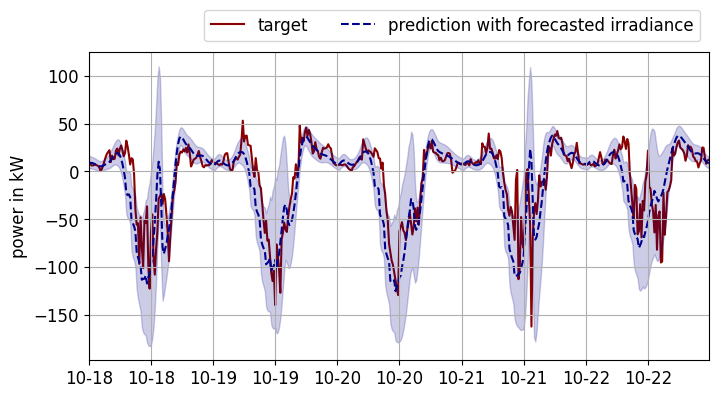

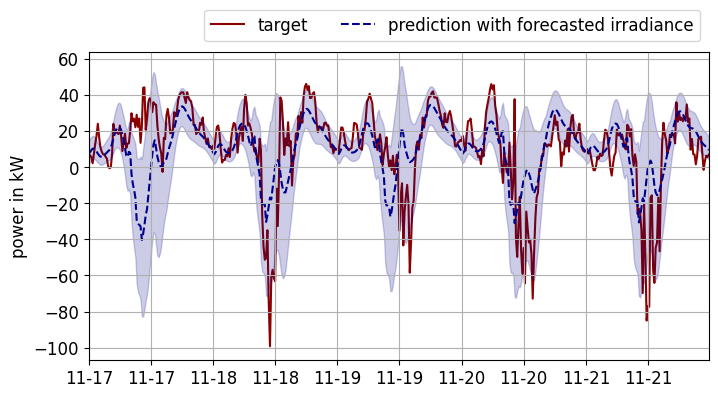

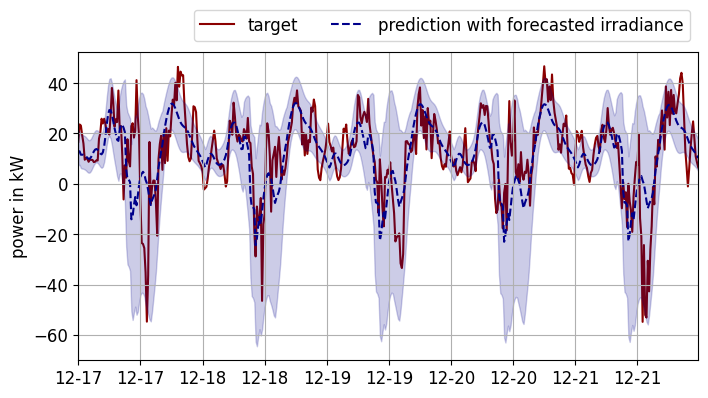

In [26]:
months = ['july', 'august', 'september', 'october', 'november', 'december']

MAE_list_original_irradiance = []
RMSE_list_original_irradiance = []

MAE_list_forecast_irradiance = []
RMSE_list_forecast_irradiance  = []

for i in range(6):
    lookback = 96
    test_values = df_test_scaled_list[i].values
    num_test_samples = test_values.shape[0]
    steps2predict = num_test_samples-lookback

    groundtruth = test_values[lookback+1::, 0] # There is a + 1 shift in the inference loop
    #groundtruth = test_values[lookback:-1, 0] 
    time = pd.Series(df_test_scaled_list[i].index)[lookback:-1]
    predictions_with_irradiance_fc, predictions_with_irradiance_fc_quantiles = run_closed_loop_quantile(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all')
    predictions_with_irradiance_original, predictions_with_irradiance_original_quantiles = run_closed_loop_quantile(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all_original')


    groundtruth = groundtruth * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_fc = predictions_with_irradiance_fc * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_original = predictions_with_irradiance_original * (max_power - min_power) + min_power #Rescale to orignal values
    
    predictions_with_irradiance_fc_quantiles = predictions_with_irradiance_fc_quantiles * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_original_quantiles = predictions_with_irradiance_original_quantiles * (max_power - min_power) + min_power #Rescale to orignal values


    fig, ax = plt.subplots(1,1, figsize=(8, 4))

    visualization_idx_start = 0#96*6
    visualization_idx_stop = visualization_idx_start + 96*5

    #print(visualization_idx_stop)
    #print(predictions_with_irradiance_fc.shape)

    ax.plot(time[visualization_idx_start:visualization_idx_stop], groundtruth[visualization_idx_start:visualization_idx_stop], label = 'target', color = 'darkred', zorder = 0)
    ax.plot(time[visualization_idx_start:visualization_idx_stop], predictions_with_irradiance_fc_quantiles[visualization_idx_start:visualization_idx_stop, 5], label = 'prediction with forecasted irradiance',linestyle = '--', color = 'darkblue', zorder = 1)
    ax.fill_between(time[visualization_idx_start:visualization_idx_stop], 
                    predictions_with_irradiance_fc_quantiles[visualization_idx_start:visualization_idx_stop, 0], 
                    predictions_with_irradiance_fc_quantiles[visualization_idx_start:visualization_idx_stop, -1], alpha=0.2, color = 'darkblue')
    
    #ax.plot(time[visualization_idx_start:visualization_idx_stop], groundtruth[visualization_idx_start:visualization_idx_stop], label = 'target', color = 'darkred', zorder = 0)
    #ax.plot(time[visualization_idx_start:visualization_idx_stop], predictions_with_irradiance_original_quantiles[visualization_idx_start:visualization_idx_stop, 5], label = 'prediction with forecasted irradiance',linestyle = '--', color = 'darkblue', zorder = 1)
    #ax.fill_between(time[visualization_idx_start:visualization_idx_stop], 
    #                predictions_with_irradiance_original_quantiles[visualization_idx_start:visualization_idx_stop, 0], 
    #                predictions_with_irradiance_original_quantiles[visualization_idx_start:visualization_idx_stop, -1], alpha=0.2, color = 'darkblue')
    ax.set_ylabel('power in kW')
    ax.legend()
    ax.grid()
    ax.xaxis.set_major_formatter(myFmt_month_day)
    ax.set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])
    ax.legend(loc='lower right', bbox_to_anchor=(1, 1.01), ncol=2)

    squared_error_forecast = (predictions_with_irradiance_fc-groundtruth)**2
    squared_error_original = (predictions_with_irradiance_original-groundtruth)**2
    absolute_error_forecast = np.abs(groundtruth - predictions_with_irradiance_fc)
    absolute_error_original = np.abs(groundtruth - predictions_with_irradiance_original)

    absolute_percentage_eror_forecast = np.abs((groundtruth - predictions_with_irradiance_fc)/groundtruth)
    absolute_percentage_eror_original = np.abs((groundtruth - predictions_with_irradiance_original)/groundtruth)

    #ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_forecast[visualization_idx_start:visualization_idx_stop], label = 'error(forecasted irradiance, groundtruth)', linestyle = '--', color = 'gray')
    #ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_original[visualization_idx_start:visualization_idx_stop], label = 'error(original irradiance, groundtruth)', color = 'black')

    #ax[1].plot(time[visualization_idx_start:visualization_idx_stop],  np.ones(len(time[visualization_idx_start:visualization_idx_stop].values)) * squared_error_forecast[visualization_idx_start:visualization_idx_stop].mean(), label = 'MSE', color = 'violet')
    
    
    
    #ax[1].legend()
    #ax[1].legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    #ax[1].grid()
    #ax[1].set_ylabel('absolute error in kW', labelpad=11)
    #ax[1].xaxis.set_major_formatter(myFmt_month_day)
    #ax[1].set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])
    #ax[0].plot(time, groundtruth, label = 'target')

    #plt.savefig(f"./paper_figures/mid_term_forecast_{months[i]}.pdf", bbox_inches='tight')
    #tikzplotlib.save(f"./paper_figures/mid_term_forecast_comparison.tex")

    mse_original_irradiance = squared_error_original.mean()
    mse_forecast_irradiance = squared_error_forecast.mean()

    mae_original_irradiance = absolute_error_original.mean()
    mae_forecast_irradiance = absolute_error_forecast.mean()

    rmse_original_irradiance = math.sqrt(mse_original_irradiance)
    #rmse_original_irradiance = mse_original_irradiance
    rmse_forecast_irradiance = math.sqrt(mse_forecast_irradiance)
    #rmse_forecast_irradiance = mse_forecast_irradiance

    print('RMSE with irradiance original:', rmse_original_irradiance) 
    print('RMSE with irradiance fc:', rmse_forecast_irradiance)
    print('MAE with irradiance original:', mae_original_irradiance) 
    print('MAE with irradiance fc:', mae_forecast_irradiance)

    MAE_list_original_irradiance.append(mae_original_irradiance)
    RMSE_list_original_irradiance.append(rmse_original_irradiance)

    MAE_list_forecast_irradiance.append(mae_forecast_irradiance)
    RMSE_list_forecast_irradiance.append(rmse_forecast_irradiance)
    #print(f'MSE increases due to uncertainty of irradiance by: {mse_forecast_irradiance/mse_original_irradiance}')

In [9]:
print(predictions_with_irradiance_fc.shape)
print(predictions_with_irradiance_fc_quantiles.shape)

(1343,)
(1343, 11)


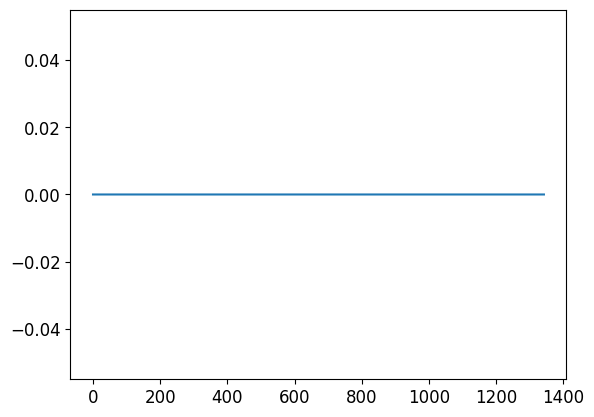

In [10]:
#plt.plot(predictions_with_irradiance_fc)
#plt.plot(predictions_with_irradiance_fc_quantiles[:,5])

plt.plot(predictions_with_irradiance_fc- predictions_with_irradiance_fc_quantiles[:,5])

### Quantile Analysis

RMSE with irradiance original: 11.698182657792598
RMSE with irradiance fc: 23.138937539896972
MAE with irradiance original: 7.512613479800612
MAE with irradiance fc: 13.826826800318951
RMSE with irradiance original: 15.404335698965616
RMSE with irradiance fc: 35.62507811457484
MAE with irradiance original: 9.143126023183768
MAE with irradiance fc: 19.781346943526806
RMSE with irradiance original: 23.874934467045602
RMSE with irradiance fc: 36.50407655922444
MAE with irradiance original: 13.84825261052427
MAE with irradiance fc: 20.880907607087078
RMSE with irradiance original: 19.36027309073996
RMSE with irradiance fc: 21.73451047075218
MAE with irradiance original: 13.283618191819578
MAE with irradiance fc: 14.325392619744525
RMSE with irradiance original: 17.340152336303408
RMSE with irradiance fc: 16.95137070091053
MAE with irradiance original: 10.763417620959578
MAE with irradiance fc: 10.793116441285527
RMSE with irradiance original: 14.87322636511974
RMSE with irradiance fc: 13.3

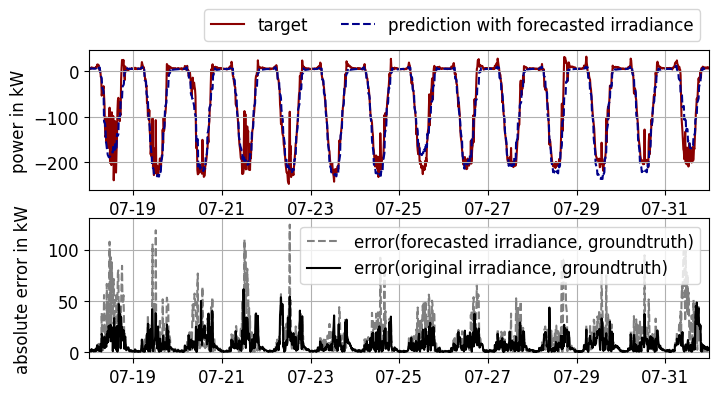

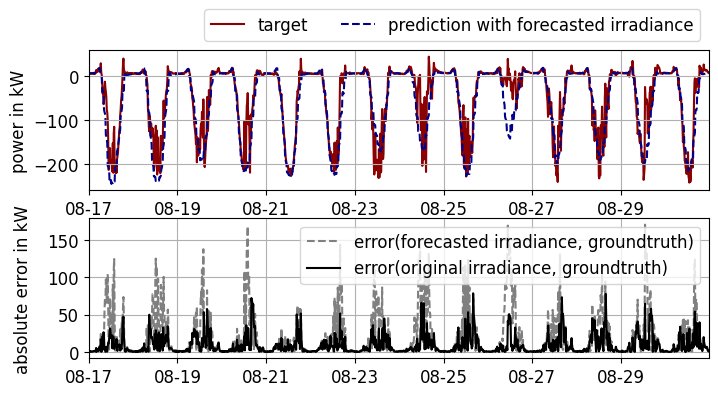

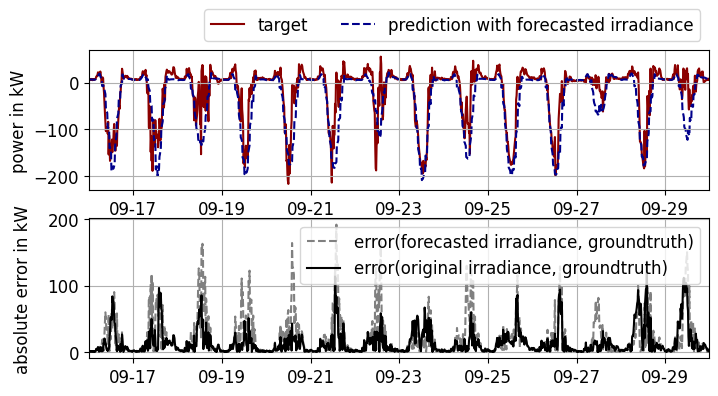

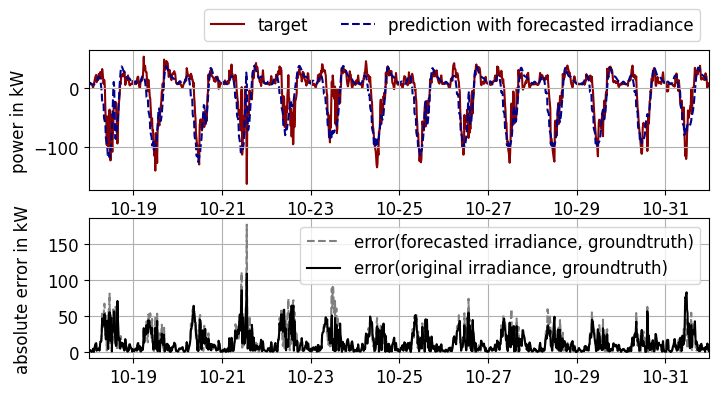

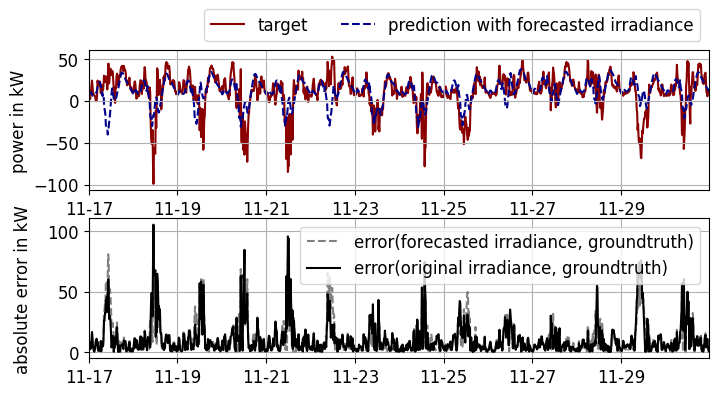

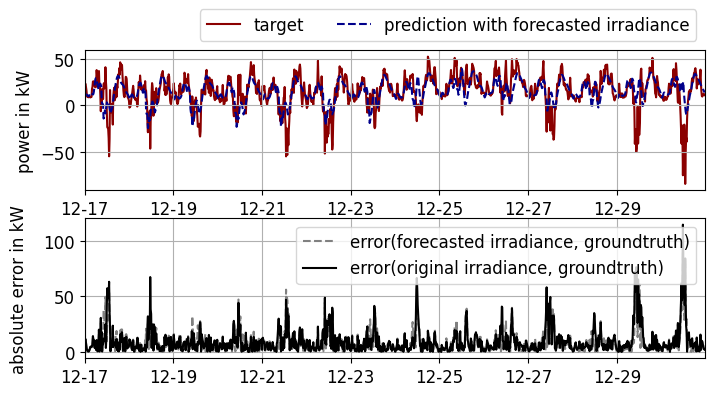

In [11]:
months = ['july', 'august', 'september', 'october', 'november', 'december']

MAE_list_original_irradiance = []
RMSE_list_original_irradiance = []

MAE_list_forecast_irradiance = []
RMSE_list_forecast_irradiance  = []

for i in range(6):
    lookback = 96
    test_values = df_test_scaled_list[i].values
    num_test_samples = test_values.shape[0]
    steps2predict = num_test_samples-lookback

    groundtruth = test_values[lookback+1::, 0] # There is a + 1 shift in the inference loop
    #groundtruth = test_values[lookback:-1, 0] 
    time = pd.Series(df_test_scaled_list[i].index)[lookback:-1]
    predictions_with_irradiance_fc, predictions_with_irradiance_fc_quantiles = run_closed_loop_quantile(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all')
    predictions_with_irradiance_original, predictions_with_irradiance_quantiles = run_closed_loop_quantile(model, test_values, lookback=lookback, future_prediction=steps2predict, use_positional_encoding='all_original')


    groundtruth = groundtruth * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_fc = predictions_with_irradiance_fc * (max_power - min_power) + min_power #Rescale to orignal values
    predictions_with_irradiance_original = predictions_with_irradiance_original * (max_power - min_power) + min_power #Rescale to orignal values

    fig, ax = plt.subplots(2,1, figsize=(8, 4))

    visualization_idx_start = 0
    visualization_idx_stop = visualization_idx_start + 96*14

    #print(visualization_idx_stop)
    #print(predictions_with_irradiance_fc.shape)

    ax[0].plot(time[visualization_idx_start:visualization_idx_stop], groundtruth[visualization_idx_start:visualization_idx_stop], label = 'target', color = 'darkred', zorder = 0)
    ax[0].plot(time[visualization_idx_start:visualization_idx_stop], predictions_with_irradiance_fc[visualization_idx_start:visualization_idx_stop], label = 'prediction with forecasted irradiance',linestyle = '--', color = 'darkblue', zorder = 1)

    ax[0].set_ylabel('power in kW')
    ax[0].legend()
    ax[0].grid()
    ax[0].xaxis.set_major_formatter(myFmt_month_day)
    ax[0].set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])

    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 1.01), ncol=2)

    squared_error_forecast = (predictions_with_irradiance_fc-groundtruth)**2
    squared_error_original = (predictions_with_irradiance_original-groundtruth)**2
    absolute_error_forecast = np.abs(groundtruth - predictions_with_irradiance_fc)
    absolute_error_original = np.abs(groundtruth - predictions_with_irradiance_original)

    absolute_percentage_eror_forecast = np.abs((groundtruth - predictions_with_irradiance_fc)/groundtruth)
    absolute_percentage_eror_original = np.abs((groundtruth - predictions_with_irradiance_original)/groundtruth)

    ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_forecast[visualization_idx_start:visualization_idx_stop], label = 'error(forecasted irradiance, groundtruth)', linestyle = '--', color = 'gray')
    ax[1].plot(time[visualization_idx_start:visualization_idx_stop], absolute_error_original[visualization_idx_start:visualization_idx_stop], label = 'error(original irradiance, groundtruth)', color = 'black')

    #ax[1].plot(time[visualization_idx_start:visualization_idx_stop],  np.ones(len(time[visualization_idx_start:visualization_idx_stop].values)) * squared_error_forecast[visualization_idx_start:visualization_idx_stop].mean(), label = 'MSE', color = 'violet')
    
    
    
    #ax[1].legend()
    ax[1].legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    ax[1].grid()
    ax[1].set_ylabel('absolute error in kW', labelpad=11)
    ax[1].xaxis.set_major_formatter(myFmt_month_day)
    ax[1].set_xlim([time[visualization_idx_start:visualization_idx_stop].values[0], time[visualization_idx_start:visualization_idx_stop].values[-1]])
    #ax[0].plot(time, groundtruth, label = 'target')

    #plt.savefig(f"./paper_figures/mid_term_forecast_{months[i]}.pdf", bbox_inches='tight')

    mse_original_irradiance = squared_error_original.mean()
    mse_forecast_irradiance = squared_error_forecast.mean()

    mae_original_irradiance = absolute_error_original.mean()
    mae_forecast_irradiance = absolute_error_forecast.mean()

    rmse_original_irradiance = math.sqrt(mse_original_irradiance)
    #rmse_original_irradiance = mse_original_irradiance
    rmse_forecast_irradiance = math.sqrt(mse_forecast_irradiance)
    #rmse_forecast_irradiance = mse_forecast_irradiance

    print('RMSE with irradiance original:', rmse_original_irradiance) 
    print('RMSE with irradiance fc:', rmse_forecast_irradiance)
    print('MAE with irradiance original:', mae_original_irradiance) 
    print('MAE with irradiance fc:', mae_forecast_irradiance)

    MAE_list_original_irradiance.append(mae_original_irradiance)
    RMSE_list_original_irradiance.append(rmse_original_irradiance)

    MAE_list_forecast_irradiance.append(mae_forecast_irradiance)
    RMSE_list_forecast_irradiance.append(rmse_forecast_irradiance)
    #print(f'MSE increases due to uncertainty of irradiance by: {mse_forecast_irradiance/mse_original_irradiance}')

### RMSE and MAE Analysis on a monthly basis

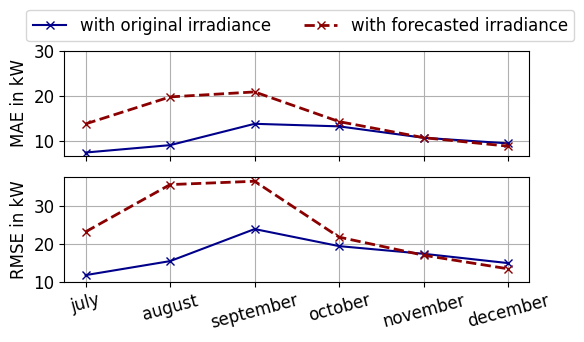

In [12]:
import warnings
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(2,1, figsize=(6, 3))

ax[0].plot(np.arange(6), MAE_list_original_irradiance, label = 'with original irradiance', marker='x', color = 'darkblue')
ax[0].plot(np.arange(6), MAE_list_forecast_irradiance, label = 'with forecasted irradiance', marker='x', linestyle = '--', linewidth=2, color = 'darkred')

ax[0].set_ylabel('MAE in kW')
ax[1].plot(np.arange(1,7), RMSE_list_original_irradiance, label = 'with original irradiance', marker='x',  color = 'darkblue')
ax[1].plot(np.arange(1,7), RMSE_list_forecast_irradiance, label = 'with forecasted irraidance', marker='x', linestyle = '--', linewidth=2, color = 'darkred')
ax[1].set_ylabel('RMSE in kW')

ax[0].set_xticklabels([])
ax[1].set_xticklabels(['dummy', 'july', 'august', 'september', 'october', 'november', 'december'], rotation = 15)

ax[1].set_yticks([10, 20, 30])
#ax[1].set_yticks([0.025, 0.05, 0.075, 0.1])
ax[0].set_yticks([10, 20, 30])

ax[0].legend(loc='lower left', bbox_to_anchor=(-0.1, 1.01), ncol=2)
#ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.savefig("./paper_figures/RMSE_MAE_monthly_basis.pdf", bbox_inches='tight')

### Computational requirements analysis 

In [13]:
class simpleLSTM_2(nn.Module):
    def __init__(self, n_input_features = 4, n_hidden = 50, num_layers = 4, n_outputs = 1, batch_first = True, bidirectional = False):
        super().__init__()
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        #n_input_features = 4
        #n_hidden = 50
        # LSTM Layer
        #self.cnn = nn.Conv1d(in_channels = n_features, out_channels=n_features, kernel_size=18, padding='same')
        self.rnn = nn.LSTM( n_input_features,
                            n_hidden,
                            num_layers,
                            batch_first=self.batch_first, 
                            bidirectional = bidirectional)
        #self.rnn = CfC(n_features, n_hidden, batch_first=False)
        if self.bidirectional:
            self.linear = nn.Linear(n_hidden*2, n_outputs)
        else:
            self.linear = nn.Linear(n_hidden, n_outputs)


    def forward(self, x, hx=None, cx=None):
        #print('input_lstm:', x.shape)
        x, hx = self.rnn(x, hx)  # hx is the hidden state of the RNN
        #x = x[:, -1, :] # Batch_first = True
        #if self.bidirectional:
            #print(x.shape)
            #x = x.view(200, -1, num_directions, hidden_size
        #print('output_lstm:', x.shape)
        x = x[:, -1, :] # Batch_first = False

        x = self.linear(x)
        #print(x.shape)
        return x, hx

In [14]:
import torch
from thop import profile
device = torch.device('cpu')

input_features = 4
model = simpleLSTM_2(n_input_features=input_features, num_layers=4, batch_first = True)
model.to(device)

steps =  1# on step prediction
#steps = int(14*24*60/15) # for 14 days --- 14 days x 24hours x 60 minutes per hour / 15 minutes resolution

print('Computational requirements:')
print('NUCLEO-L432KC@80MHz (ARM Cortex M4) -  RAM:640kB FLASH:2MB -- ~12M MACs/s')
print(f'predicted time steps: {steps}')

input = torch.randn(1, steps+1, input_features)
#print('generated input_shape', input.shape)
total_macs, total_parameters = profile(model, inputs=(input, ) , verbose=False)
print('MACs', int(total_macs))
print('total_parameters', int(total_parameters))

# Lets consider the Edge Device Deployment on an MCU platform with a Floating Point Unit:
# 1 paramerter is stored with 4 Bytes
#  NUCLEO-L432KC@80MHz (ARM Cortex M4) -  RAM:640kB FLASH:2MB -- 12.16M MACs/s
MACs_per_second = 12*1e6
KBFlash = (total_parameters * 4) / 1024

print('Latency in s:', total_macs/MACs_per_second)
print('Stoarge needed for deployment in kB:', KBFlash)

Computational requirements:
NUCLEO-L432KC@80MHz (ARM Cortex M4) -  RAM:640kB FLASH:2MB -- ~12M MACs/s
predicted time steps: 1
MACs 148050
total_parameters 72451
Latency in s: 0.0123375
Stoarge needed for deployment in kB: 283.01171875
